In [32]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import librosa
from sklearn.utils.multiclass import unique_labels



In [2]:
#directory to training data and json file
train_dir='/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-train/audio/'
#directory to training data and json file
valid_dir='/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-valid/audio/'
#directory to training data and json file
test_dir='/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-test/audio/'

## Feature Extract

In [3]:
def feature_extract(file):
    """
    Define function that takes in a file an returns features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    #compute chroma energy
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, chroma, contrast]

In [17]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

In [5]:
#get the training
with open('DataWrangling/filenames_train.pickle', 'rb') as f:
    filenames_train = pickle.load(f)

In [8]:
#load the json files
df_train= pd.read_json('/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-train/examples.json', orient='index')

In [11]:
#exclude all files in training dataset
df_train_mod = df_train[~df_train.index.isin(filenames_train)]
df_train_mod.shape

(239205, 13)

In [12]:
#Sample n files
df_train_sample=df_train_mod.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(1000)) #number of samples
#drop the synth_lead from the training dataset
df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]

df_train_sample.shape

(10000, 13)

In [13]:
#save the train file index as list
filenames = df_train_sample.index.tolist()

In [16]:
#create dictionary to store all test features
dict_test = {}
#loop over every file in the list
for file in filenames:
    #extract the features
    features = feature_extract(train_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_test[file] = features

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [18]:
#convert dict to dataframe
features_test = pd.DataFrame.from_dict(dict_test, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

In [21]:
targets_test = []
for name in features_test.index.tolist():
    targets_test.append(instrument_code(name))

features_test['targets'] = targets_test

In [22]:
#extract mfccs
mfcc_test = pd.DataFrame(features_test.mfcc.values.tolist(),index=features_test.index)
mfcc_test = mfcc_test.add_prefix('mfcc_')

#extract spectro
spectro_test = pd.DataFrame(features_test.spectro.values.tolist(),index=features_test.index)
spectro_test = spectro_test.add_prefix('spectro_')


#extract chroma
chroma_test = pd.DataFrame(features_test.chroma.values.tolist(),index=features_test.index)
chroma_test = chroma_test.add_prefix('chroma_')


#extract contrast
contrast_test = pd.DataFrame(features_test.contrast.values.tolist(),index=features_test.index)
contrast_test = chroma_test.add_prefix('contrast_')

#drop the old columns
features_test = features_test.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_test=pd.concat([features_test, mfcc_test, spectro_test, chroma_test, contrast_test],
                           axis=1, join='inner')
df_features_test.head()

,harmonic,targets,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_electronic_004-046-025,0,0,-499.344339,50.845920,37.415199,30.128452,22.023434,15.067691,9.115178,3.255047,...,0.029262,0.038886,0.041576,0.040762,0.046410,0.050698,0.092661,0.528389,0.636725,0.439625
bass_synthetic_045-097-127,0,0,-208.520632,62.484986,-59.531511,55.899905,-15.802928,30.184138,-32.448381,13.595960,...,0.452264,0.211559,0.197093,0.113437,0.108910,0.134160,0.133031,0.146251,0.189056,0.189652
bass_synthetic_051-071-050,1,0,-397.024217,12.835646,2.807544,8.216464,-27.402290,-7.273604,-29.580155,-19.107302,...,0.025324,0.021995,0.013131,0.024104,0.046232,0.039298,0.025580,0.022734,0.498987,0.670291
bass_synthetic_121-073-100,1,0,-480.360712,20.176966,2.423125,1.136143,-21.009141,-13.433699,-15.630798,-6.444302,...,0.457709,0.023681,0.029090,0.040140,0.029108,0.040849,0.047041,0.046758,0.055298,0.123167
bass_synthetic_105-046-050,0,0,-388.832358,139.085235,46.588885,19.759009,25.584054,17.972531,8.160255,5.761977,...,0.089414,0.046594,0.042685,0.002515,0.021122,0.074585,0.031109,0.459536,0.646207,0.489804


In [23]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_test_sensitive.pickle', 'wb') as f:
    pickle.dump(df_features_test, f)

# Test The New Data

In [26]:
#get the classifier
with open('SavedModels/random_search_RF.pickle', 'rb') as f:
    clf_rf = pickle.load(f)

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

In [28]:
class_names=np.array(['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal'])

In [29]:
X_test = df_features_test.drop(labels=['targets'], axis=1)
y_test = df_features_test['targets']

In [30]:
y_pred_RF = clf_rf.predict(X_test)
accuracy_RF = np.mean(y_pred_RF == y_test)
print("The accuracy of Random Forest is {0:.2%}".format(accuracy_RF))

The accuracy of Random Forest is 85.67%


Normalized confusion matrix
[[0.685 0.008 0.012 0.071 0.083 0.085 0.017 0.019 0.013 0.007]
 [0.002 0.961 0.003 0.    0.003 0.001 0.001 0.008 0.018 0.003]
 [0.006 0.008 0.955 0.    0.005 0.    0.003 0.016 0.005 0.002]
 [0.066 0.013 0.    0.708 0.075 0.104 0.013 0.004 0.016 0.001]
 [0.063 0.013 0.011 0.081 0.712 0.065 0.019 0.017 0.008 0.011]
 [0.024 0.009 0.005 0.036 0.045 0.852 0.005 0.002 0.008 0.014]
 [0.016 0.015 0.006 0.007 0.034 0.014 0.888 0.007 0.005 0.008]
 [0.027 0.029 0.03  0.005 0.003 0.001 0.002 0.882 0.019 0.002]
 [0.004 0.001 0.004 0.009 0.005 0.004 0.002 0.008 0.962 0.001]
 [0.007 0.013 0.002 0.    0.001 0.001 0.001 0.009 0.004 0.962]]


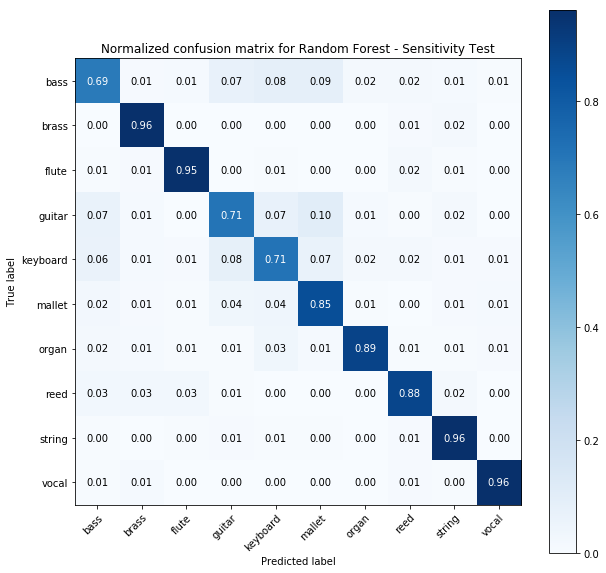

In [34]:
plot_confusion_matrix(y_test, y_pred_RF, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for Random Forest - Sensitivity Test')
plt.savefig('ConfusionMatrix/RF_Normalized_sensitive.png')